# C02. Players

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Utilities.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"

### Goals:
- Compare my FP projections to actual FP scored
    - Main breakdowns
        - Batters
            - Overall
            - Lefty*
            - Righty*
            - Unimputed
            - Imputed
            - Unsubbed
        - Pitchers (SP only)
            - Overall
            - Lefty*
            - Righty*
            - Unimputed
            - Imputed
    - By projection quantile
        - Batters
        - Pitchers (SP only)
    - By park
        - Batters
        - Pitchers (SP only)
    - By year
        - Batters
        - Pitchers (SP only)

- Compare my scoring component projections to actual scoring component scoring (projected singles vs. actual singles, etc...) (mean)
    - Batters
    - Pitchers (SP only)
    
- Compare my FP projections to other FP projections (mean, MSE)
    - Batters
    - Pitchers (SP only)

### Dates

In [2]:
start_date = "20240318"
# end_date = yesterdaysdate
end_date = "20240930"

# start_date = todaysdate
# end_date = todaysdate

### Games

Games played

In [3]:
game_df = create_games(start_date, end_date, team_dict)
# game_df = pd.read_pickle(os.path.join(baseball_path, "game_df.pkl"))

Dates and games with my projections

In [4]:
date_mask = (game_df['date'] >= start_date) & (game_df['date'] <= end_date) 
date_list = list(game_df[date_mask]['date'].unique())
date_folders = [f"Matchups {date}" for date in date_list]
date_folders = [date_folder for date_folder in os.listdir(r"C:\Users\james\Documents\MLB\Database\B02. Simulations\2. Player Sims") and date_folders]

game_list = list(game_df[date_mask]['game_id'].unique())
player_folders = [f"Players {game}" for game in game_list]

### Functions

Extract date, teams, and gamePk from folder names

In [5]:
def extract_info_from_folder(date_folder, matchup_folder):
    # Extract date from date folder
    date = date_folder.split(' ')[1]
    
    # Extract teams and gamePK from matchup folder
    parts = matchup_folder.split(' ')
    away_team, home_team = parts[0].split('@')
    gamePk = parts[1]
    
    return date, away_team, home_team, gamePk

Average player stats for a given position group

In [6]:
def game_averages(date_folder, matchup_folder, position='pitchers'):
    date, away_team, home_team, gamePk = extract_info_from_folder(date_folder, matchup_folder)
    
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Get a list of all CSV files in the matchup folder
    csv_files = [file for file in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder, matchup_folder)) 
                 if file.startswith(position) and file.endswith('.csv')]
    
    # Iterate over each CSV file
    for csv_file in csv_files:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder, matchup_folder, csv_file))
        
        # Append date, away_team, home_team, and gamePk columns
        df['date'] = date
        df['away_team'] = away_team
        df['home_team'] = home_team
        df['gamePk'] = gamePk
        
        # Append the DataFrame to the list
        dfs.append(df)
    
    # Concatenate all DataFrames in the list
    combined_df = pd.concat(dfs)
    
    # Select numeric columns
    numeric_cols = combined_df.select_dtypes(include='number')
    
    # Group by fullName and calculate the mean for numeric columns
    averaged_numeric_cols = numeric_cols.groupby(combined_df['fullName'], sort=False).mean()
    
    # Select team and additional columns
    additional_cols = combined_df[['fullName', 'team', 'date', 'away_team', 'home_team', 'gamePk']].drop_duplicates('fullName').set_index('fullName')
    
    # Concatenate numeric and additional columns
    averaged_df = pd.concat([additional_cols, averaged_numeric_cols], axis=1).reset_index()

    averaged_df['team_abbrev'] = np.where(averaged_df['team'] == "away", averaged_df['away_team'], averaged_df['home_team'])

    averaged_df['starter'] = (~averaged_df['team'].duplicated()).astype(int)

    return averaged_df

### Player Sim Files

Calculate averages for player stats in simulations by game

##### Batters

Calculate averages

In [7]:
%%time
position = 'batters'

# Parallelize the loop using joblib and directly return df_list
batter_df_list = Parallel(n_jobs=-1)(
    delayed(game_averages)(date_folder, matchup_folder, position) 
    for date_folder in date_folders 
    for matchup_folder in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder)))

CPU times: total: 9.27 s
Wall time: 46.3 s


Write to CSV

In [8]:
for df in batter_df_list:
    gamePk = df['gamePk'][0]
    away_df = df.query('team == "away"')
    home_df = df.query('team == "home"')
    
    # Create folder
    os.makedirs(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}"), exist_ok=True)

    # Write to csv
    away_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away batters projections {gamePk}.csv"), index=False)
    home_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home batters projections {gamePk}.csv"), index=False)

##### Pitchers

Calculate averages

In [9]:
%%time
position = 'pitchers'

# Parallelize the loop using joblib and directly return df_list
pitcher_df_list = Parallel(n_jobs=-1)(
    delayed(game_averages)(date_folder, matchup_folder, position) 
    for date_folder in date_folders 
    for matchup_folder in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder)))

CPU times: total: 11.7 s
Wall time: 44 s


Write to CSV

In [10]:
for df in pitcher_df_list:
    gamePk = df['gamePk'][0]
    away_df = df.query('team == "away"')
    home_df = df.query('team == "home"')
    
    # Create folder
    os.makedirs(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}"), exist_ok=True)

    # Write to csv
    away_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away pitchers projections {gamePk}.csv"), index=False)
    home_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home pitchers projections {gamePk}.csv"), index=False)

### Player Scoring

Add players' actual scoring onto simulated projections

##### Batters

In [11]:
# Define a function to process each folder
def process_batters(folder):
    # Extract gamePk
    gamePk = folder.split(" ")[1]

    ### Batters
    ## Away
    # Read in projections
    away_batter_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away batters projections {gamePk}.csv"))
    # Read in results
    away_batter_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"away batters {gamePk}.csv"))

    # Merge
    away_batters_merged = away_batter_projected_results_df[['fullName', 'id', 'imp_b_l', 'imp_b_r', 'PA', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'SB', 'R', 'RBI', 'FP', 'gamePk']].merge(away_batter_actual_results_df, left_on=['id', 'gamePk'], right_on=['personId', 'gamePk'], how='outer')

    ## Home
    # Read in projections
    home_batter_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home batters projections {gamePk}.csv"))
    # Read in results
    home_batter_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"home batters {gamePk}.csv"))

    # Merge
    home_batters_merged = home_batter_projected_results_df[['fullName', 'id', 'imp_b_l', 'imp_b_r', 'PA', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'SB', 'R', 'RBI', 'FP', 'gamePk']].merge(home_batter_actual_results_df, left_on=['id', 'gamePk'], right_on=['personId', 'gamePk'], how='outer')

    # Append them together
    batters_merged = pd.concat([away_batters_merged, home_batters_merged], axis=0)

    
    return batters_merged

In [12]:
def process_batters2(folder):
    try:
        batters_merged = process_batters(folder)    
        return batters_merged   
    except:
        pass 

In [13]:
%%time
# Run the loop in parallel
batters_merged_list = Parallel(n_jobs=-1)(delayed(process_batters2)(folder) for folder in player_folders)
batters_merged_df = pd.concat(batters_merged_list, axis=0)

CPU times: total: 5.28 s
Wall time: 9.68 s


##### Pitchers

In [14]:
def process_pitchers(folder):
    # Extract gamePk
    gamePk = folder.split(" ")[1]
    
    ### Pitchers
    ## Away
    # Read in projections
    away_pitcher_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away pitchers projections {gamePk}.csv"))
    away_pitcher_projected_results_df['team'] = "away"
    # Read in results
    away_pitcher_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"away pitchers {gamePk}.csv"))

    # Merge
    away_pitchers_merged = away_pitcher_projected_results_df[['fullName', 'id', 'imp_p_l', 'imp_p_r', 'OUT', 'PA', 'SO', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'H', 'R', 'ER', 'W', 'CG', 'CGSO', 'NH', 'FP', 'team', 'gamePk']].merge(away_pitcher_actual_results_df, left_on=['id', 'gamePk', 'team'], right_on=['personId', 'gamePk', 'team'], how='outer')
    
    ## Home
    # Read in projections
    home_pitcher_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home pitchers projections {gamePk}.csv"))
    home_pitcher_projected_results_df['team'] = "home"
    # Read in results
    home_pitcher_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"home pitchers {gamePk}.csv"))

    # Merge
    home_pitchers_merged = home_pitcher_projected_results_df[['fullName', 'id', 'imp_p_l', 'imp_p_r', 'OUT', 'PA', 'SO', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'H', 'R', 'ER', 'W', 'CG', 'CGSO', 'NH', 'FP', 'team', 'gamePk']].merge(home_pitcher_actual_results_df, left_on=['id', 'gamePk', 'team'], right_on=['personId', 'gamePk', 'team'], how='outer')

    # Append them together
    pitchers_merged = pd.concat([away_pitchers_merged, home_pitchers_merged], axis=0)

    
    return pitchers_merged

In [15]:
def process_pitchers2(folder):
    try:
        pitchers_merged = process_pitchers(folder)    
        return pitchers_merged   
    except:
        pass 

In [16]:
%%time
# Run the loop in parallel
pitchers_merged_list = Parallel(n_jobs=-1)(delayed(process_pitchers2)(folder) for folder in player_folders)
pitchers_merged_df = pd.concat(pitchers_merged_list, axis=0)

CPU times: total: 5.22 s
Wall time: 9.51 s


### 1. Player Stat Evaluations

Compare simulated projections to player stats

In [17]:
player_stat_path = os.path.join(baseball_path, "C02. Players", "1. Player Stat Evaluations", f"Player Stat Evaluations {todaysdate}.xlsx")

##### Batters

Create New Variables

In [18]:
# Actual singles
batters_merged_df['singles'] = batters_merged_df['h'] - batters_merged_df['doubles'] - batters_merged_df['triples'] - batters_merged_df['hr']
# Actual PA
batters_merged_df['pa'] = batters_merged_df[['ab', 'bb', 'hbp']].sum(axis=1)
# Projected hits
batters_merged_df['H'] = batters_merged_df[['B1', 'B2', 'B3', 'HR']].sum(axis=1)
# Reached
batters_merged_df['ON'] = batters_merged_df[['H', 'BB', 'HBP']].sum(axis=1)
batters_merged_df['on'] = batters_merged_df[['h', 'bb', 'hbp']].sum(axis=1)

In [19]:
# Identify number of batters that batted in a given spot in the order (we may only want those who were never subbed out or are subs)
batters_merged_df['battingSpot'] = batters_merged_df['battingOrder'] // 100
# Instance of batter in that spot
# Example:
# Three batters batted 4
# All three would have battingSpot = 4
# battingSpotInstance for starter would be 1, the first sub would be 2, second sub would be 3
batters_merged_df['battingSpotInstance'] = batters_merged_df.groupby(['gamePk', 'team', 'battingSpot'])['battingSpot'].transform('count')

##### Starters

In [20]:
all_batters = batters_merged_df.query('battingSpotInstance == 1')[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = all_batters.T.iloc[::2].reset_index()
actual = all_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
all_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
all_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Write to Excel
all_batters.to_excel(player_stat_path, sheet_name='AllBatters', index=False)

##### Starters - Unimputed

In [21]:
# def batter_stats(batters_merged_df, starters_only=False, imputation_status='both'):
#     # Determine battingSpotInstance
#     if starters_only == True:
#         battingSpotInstance_mask = (df['battingSpotInstance'] == 1)
#     if imputation_status == 'imputed':
#         imputation_mask = (df['imp_b_l'] == 1 | df['imp_b_r'] == 1)
        
#     df = batters_merged_df.query('battingSpotInstance == 1').query('imp_b_l == 0 & imp_b_r == 0')[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

In [22]:
# unimputed_batters = batters_merged_df.query('battingSpotInstance == 1').query('imp_b_l == 0 & imp_b_r == 0')[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])
# unimputed_batters.head()

In [23]:
unimputed_batters = batters_merged_df.query('battingSpotInstance == 1').query('imp_b_l == 0 & imp_b_r == 0')[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = unimputed_batters.T.iloc[::2].reset_index()
actual = unimputed_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
unimputed_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
unimputed_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Set Projected Share
unimputed_batters['Projected Share'] = 0.0
unimputed_batters.loc[unimputed_batters['Projected'] == 'PA', 'Projected Share'] = 1
unimputed_batters.loc[unimputed_batters['Projected'] == 'ON', 'Projected Share'] = (
    unimputed_batters.loc[unimputed_batters['Projected'] == 'ON', 'Projected Mean'].values[0] /
    unimputed_batters.loc[unimputed_batters['Projected'] == 'PA', 'Projected Mean'].values[0]
)
unimputed_batters.loc[~unimputed_batters['Projected'].isin(['PA', 'ON']), 'Projected Share'] = (
    unimputed_batters.loc[~unimputed_batters['Projected'].isin(['PA', 'ON']), 'Projected Mean'] /
    unimputed_batters.loc[unimputed_batters['Projected'] == 'ON', 'Projected Mean'].values[0]
)

# Set Actual Share
unimputed_batters['Actual Share'] = 0.0
unimputed_batters.loc[unimputed_batters['Actual'] == 'pa', 'Actual Share'] = 1
unimputed_batters.loc[unimputed_batters['Actual'] == 'on', 'Actual Share'] = (
    unimputed_batters.loc[unimputed_batters['Actual'] == 'on', 'Actual Mean'].values[0] /
    unimputed_batters.loc[unimputed_batters['Actual'] == 'pa', 'Actual Mean'].values[0]
)
unimputed_batters.loc[~unimputed_batters['Actual'].isin(['pa', 'on']), 'Actual Share'] = (
    unimputed_batters.loc[~unimputed_batters['Actual'].isin(['pa', 'on']), 'Actual Mean'] /
    unimputed_batters.loc[unimputed_batters['Actual'] == 'on', 'Actual Mean'].values[0]
)

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    unimputed_batters.to_excel(writer, sheet_name='UnimputedBatters', index=False)
    
unimputed_batters

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum,Projected Share,Actual Share
0,PA,4.219009,146125.360000,pa,4.139079,143357.0,1.000000,1.000000
1,ON,1.318104,45652.549167,on,1.304057,45166.0,0.312420,0.315060
2,H,0.930980,32244.507500,h,0.921351,31911.0,0.706302,0.706527
3,B1,0.608360,21070.558333,singles,0.596709,20667.0,0.461542,0.457579
4,B2,0.175640,6083.276667,doubles,0.179327,6211.0,0.133252,0.137515
5,B3,0.016949,587.025000,triples,0.015938,552.0,0.012859,0.012222
6,HR,0.130032,4503.647500,hr,0.129378,4481.0,0.098651,0.099212
7,BB,0.343242,11888.170000,bb,0.340465,11792.0,0.260405,0.261081
8,SB,0.073389,2541.814167,sb,0.084192,2916.0,0.055677,0.064562
9,FP,7.171867,248397.597500,fp,7.225870,250268.0,5.441046,5.541071


In [24]:
1-unimputed_batters['Projected Mean'][1] / unimputed_batters['Projected Mean'][0]

np.float64(0.6875795606822342)

In [25]:
1-unimputed_batters['Actual Mean'][1] / unimputed_batters['Actual Mean'][0]

np.float64(0.6849403935629234)

##### Starters - Imputed

In [26]:
imputed_batters = batters_merged_df.query('battingSpotInstance == 1').query('imp_b_l == 1 | imp_b_r == 1')[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = imputed_batters.T.iloc[::2].reset_index()
actual = imputed_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
imputed_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
imputed_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    imputed_batters.to_excel(writer, sheet_name='ImputedBatters', index=False)
    
imputed_batters

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,PA,4.012110,10571.9100,pa,3.910816,10305.0
1,ON,1.238780,3264.1850,on,1.159013,3054.0
2,H,0.881474,2322.6850,h,0.829602,2186.0
3,B1,0.581820,1533.0950,singles,0.554459,1461.0
4,B2,0.152625,402.1675,doubles,0.155218,409.0
5,B3,0.019959,52.5925,triples,0.015560,41.0
6,HR,0.127070,334.8300,hr,0.104364,275.0
7,BB,0.313116,825.0600,bb,0.292979,772.0
8,SB,0.072377,190.7125,sb,0.087287,230.0
9,FP,6.804787,17930.6150,fp,6.338520,16702.0


##### Teams

In [27]:
team_batters = batters_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True)[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'HBP', 'hbp', 'R', 'r', 'RBI', 'rbi', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = team_batters.T.iloc[::2].reset_index()
actual = team_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
team_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
team_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    team_batters.to_excel(writer, sheet_name='TeamBatters', index=False)
    
team_batters

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,PA,37.746998,181940.530000,pa,37.167012,179145.0
1,ON,11.781175,56785.262500,on,11.665768,56229.0
2,H,8.311988,40063.784167,h,8.191286,39482.0
3,B1,5.431402,26179.360000,singles,5.325311,25668.0
4,B2,1.574238,7587.826667,doubles,1.600830,7716.0
5,B3,0.155419,749.119167,triples,0.142739,688.0
6,HR,1.150929,5547.478333,hr,1.122407,5410.0
7,BB,3.075388,14823.369167,bb,3.075104,14822.0
8,HBP,0.393799,1898.109167,hbp,0.399378,1925.0
9,R,4.298075,20716.720000,r,4.392946,21174.0


In [28]:
1-team_batters['Projected Mean'][1] / team_batters['Projected Mean'][0]

np.float64(0.6878910790245583)

In [29]:
1-team_batters['Actual Mean'][1] / team_batters['Actual Mean'][0]

np.float64(0.6861257640458847)

##### Scaled

In [30]:
actual_pa_mean = batters_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True)['pa'].mean()
projected_pa_mean = batters_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True)['PA'].mean()

In [31]:
# Define the fraction
fraction = actual_pa_mean/projected_pa_mean

# Select the columns you want to multiply and multiply them by the fraction
columns_to_multiply = ['PA', 'H', 'B1', 'B2', 'B3', 'HR', 'BB', 'HBP', 'R', 'RBI', 'SB', 'FP']
batters_merged_df_scaled = batters_merged_df.copy()
batters_merged_df_scaled[columns_to_multiply] = batters_merged_df[columns_to_multiply] * fraction

In [32]:
scaled_batters = batters_merged_df_scaled.groupby(['gamePk', 'team']).sum(numeric_only=True)[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'HBP', 'hbp', 'R', 'r', 'RBI', 'rbi', 'SB', 'sb', 'FP', 'fp']]

# Convert to DF
scaled_batters = pd.DataFrame(scaled_batters.mean().reset_index())

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = scaled_batters.iloc[::2].reset_index(drop=True)
actual = scaled_batters.iloc[1::2].reset_index(drop=True)

# Concatenate the two dataframes side-by-side
scaled_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
scaled_batters.columns = ["Projected", "Projected Value", "Actual", "Actual Value"]

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    scaled_batters.to_excel(writer, sheet_name='ScaledBatters', index=False)

scaled_batters

,Projected,Projected Value,Actual,Actual Value
0,PA,37.167012,pa,37.167012
1,ON,11.781175,on,11.665768
2,H,8.184274,h,8.191286
3,B1,5.347949,singles,5.325311
4,B2,1.550050,doubles,1.600830
5,B3,0.153031,triples,0.142739
6,HR,1.133245,hr,1.122407
7,BB,3.028134,bb,3.075104
8,HBP,0.387748,hbp,0.399378
9,R,4.232034,r,4.392946


##### Park

In [33]:
batter_park_fp = batters_merged_df.query('battingSpotInstance == 1').groupby('venue_id')[['FP', 'fp']].agg(['mean']).reset_index()
batter_park_fp.columns = ['VENUE_ID', 'FP', 'fp']
batter_park_fp = pd.merge(batter_park_fp, team_map[['VENUE_ID', 'BBREFTEAM']], on='VENUE_ID', how='left')

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    batter_park_fp.to_excel(writer, sheet_name='ParkBatters', index=False)
    
batter_park_fp

,VENUE_ID,FP,fp,BBREFTEAM
0,1,7.326053,7.318253,LAA
1,2,6.941830,7.319871,BAL
2,3,7.108490,7.549918,BOS
3,4,6.557295,6.790193,CHW
4,5,6.935285,7.184539,CLE
5,7,7.686210,7.042940,KCR
6,10,7.085176,6.845209,OAK
7,12,6.914031,6.918086,TBR
8,14,7.247244,7.102362,TOR
9,15,7.631536,7.941176,ARI


##### Year

In [34]:
batter_year_fp = batters_merged_df.query('battingSpotInstance == 1').groupby('year')[['FP', 'fp']].agg(['mean']).reset_index()
batter_year_fp.columns = ['year', 'FP', 'fp']

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    batter_year_fp.to_excel(writer, sheet_name='YearBatters', index=False)
    
batter_year_fp

,year,FP,fp
0,2024,7.145914,7.163134


In [35]:
# Consider tracking if players were never removed from game
# Consider merging on innings and only looking at full games
# Consider adding lefty/righty 

#### Pitchers

##### Create New Variables

In [36]:
pitchers_merged_df.sort_values(['gamePk', 'team', 'date'], inplace=True)

In [37]:
pitchers_merged_df['personId'].fillna(pitchers_merged_df['id'], inplace=True)
pitchers_merged_df['name'].fillna(pitchers_merged_df['fullName'], inplace=True)

for col in ['starter', 'ip', 'outs', 'h', 'r', 'er', 'bb', 'k', 'hr', 'hbp', 'w', 'l', 'cg', 'cgso', 'nh', 'fp']:
    pitchers_merged_df[col].fillna(0, inplace=True)
    
for col in ['date', 'year', 'venue_id', 'team', 'teamabbrev']:
    # pitchers_merged_df.sort_values(['date', 'year', 'venue_id', 'team', 'teamabbrev'], ascending=False, inplace=True)
    pitchers_merged_df[col].fillna(method='ffill', inplace=True)

##### Starters

In [38]:
all_pitchers = pitchers_merged_df.dropna().query('starter == 1')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'H', 'h', 'SO', 'k', 'W', 'w', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = all_pitchers.T.iloc[::2].reset_index()
actual = all_pitchers.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
all_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
all_pitchers.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    all_pitchers.to_excel(writer, sheet_name='AllPitchers', index=False)
    
all_pitchers

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,OUT,15.827212,76065.582083,outs,15.672285,75321.00
1,PA,22.370167,107511.024583,pa,22.039950,105924.00
2,ER,2.359687,11340.655417,er,2.411985,11592.00
3,R,2.570817,12355.346667,r,2.590304,12449.00
4,H,5.050237,24271.440417,h,4.932376,23705.00
5,SO,4.983510,23950.748333,k,4.841864,23270.00
6,W,0.303992,1460.983333,w,0.294216,1414.00
7,FP,14.160171,68053.780479,fp,13.724459,65959.75


##### Starters - Unimputed

In [39]:
unimputed_pitchers = pitchers_merged_df.dropna().query('starter == 1').query('imp_p_l == 0 & imp_p_r == 0')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'H', 'h', 'SO', 'k', 'W', 'w', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = unimputed_pitchers.T.iloc[::2].reset_index()
actual = unimputed_pitchers.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
unimputed_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
unimputed_pitchers.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", "Actual Sum"]

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    unimputed_pitchers.to_excel(writer, sheet_name='UnimputedPitchers', index=False)

unimputed_pitchers

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,OUT,15.932297,72460.087083,outs,15.779903,71767.00
1,PA,22.483168,102253.447083,pa,22.156772,100769.00
2,ER,2.345321,10666.520417,er,2.406772,10946.00
3,R,2.558928,11638.004167,r,2.584653,11755.00
4,H,5.061068,23017.735417,h,4.951627,22520.00
5,SO,5.017915,22821.478333,k,4.890721,22243.00
6,W,0.308679,1403.870833,w,0.299252,1361.00
7,FP,14.350837,65267.608229,fp,13.924373,63328.05


##### Starters - Imputed

In [40]:
imputed_pitchers = pitchers_merged_df.dropna().query('starter == 1').query('imp_p_l == 1 | imp_p_r == 1')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'H', 'h', 'SO', 'k', 'W', 'w', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = imputed_pitchers.T.iloc[::2].reset_index()
actual = imputed_pitchers.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
imputed_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
imputed_pitchers.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", "Actual Sum"]

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    imputed_pitchers.to_excel(writer, sheet_name='ImputedPitchers', index=False)

imputed_pitchers

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,OUT,13.974787,3605.49500,outs,13.775194,3554.0
1,PA,20.378207,5257.57750,pa,19.980620,5155.0
2,ER,2.612926,674.13500,er,2.503876,646.0
3,R,2.780397,717.34250,r,2.689922,694.0
4,H,4.859322,1253.70500,h,4.593023,1185.0
5,SO,4.377016,1129.27000,k,3.980620,1027.0
6,W,0.221366,57.11250,w,0.205426,53.0
7,FP,10.799117,2786.17225,fp,10.200388,2631.7


##### Scaled

This calculates how starting pitchers would do if they went as long as they were supposed to. <br>
Note: outs should have a nonlinear relationship with wins, so this won't be exactly right, but close enough. 

In [41]:
actual_outs_mean = pitchers_merged_df.dropna().query('starter == 1')['outs'].mean()
projected_outs_mean = pitchers_merged_df.dropna().query('starter == 1')['OUT'].mean()

In [42]:
# Define the fraction
fraction = actual_outs_mean/projected_outs_mean

# Select the columns you want to multiply and multiply them by the fraction
columns_to_multiply = ['OUT', 'ER', 'R', 'SO', 'FP']
pitchers_merged_df_scaled = pitchers_merged_df.copy()
pitchers_merged_df_scaled[columns_to_multiply] = pitchers_merged_df_scaled[columns_to_multiply] * fraction

In [43]:
# Describe the DataFrame
pitchers_scaled = pitchers_merged_df_scaled.dropna().query('starter == 1')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'SO', 'k', 'W', 'w', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = pitchers_scaled.T.iloc[::2].reset_index()
actual = pitchers_scaled.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
pitchers_scaled = pd.concat([projected, actual], axis=1)

# Rename the columns
pitchers_scaled.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pitchers_scaled.to_excel(writer, sheet_name='ScaledPitchers', index=False)

pitchers_scaled

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,OUT,15.672285,75321.000000,outs,15.672285,75321.00
1,PA,22.370167,107511.024583,pa,22.039950,105924.00
2,ER,2.336589,11229.645304,er,2.411985,11592.00
3,R,2.545652,12234.404060,r,2.590304,12449.00
4,SO,4.934728,23716.301983,k,4.841864,23270.00
5,W,0.303992,1460.983333,w,0.294216,1414.00
6,FP,14.021561,67387.623404,fp,13.724459,65959.75


##### Teams

In [44]:
team_pitchers = pitchers_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True).query('outs >= 24')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'SO', 'k', 'H', 'h', 'BB', 'bb', 'HR', 'hr', 'FP', 'fp']].agg(['mean'])

# Convert to DF
team_pitchers = pd.DataFrame(team_pitchers.mean().reset_index())

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = team_pitchers.iloc[::2].reset_index(drop=True)
actual = team_pitchers.iloc[1::2].reset_index(drop=True)

# Concatenate the two dataframes side-by-side
team_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
team_pitchers.columns = ["Projected", "Projected Value", "Actual", "Actual Value"]

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    team_pitchers.to_excel(writer, sheet_name='TeamPitchers', index=False)

team_pitchers

,Projected,Projected Value,Actual,Actual Value
0,OUT,26.704840,outs,26.634476
1,PA,37.737694,pa,37.523157
2,ER,3.855293,er,4.025961
3,R,4.296995,r,4.392731
4,SO,8.696602,k,8.481828
5,H,8.310491,h,8.192316
6,BB,3.073664,bb,3.075182
7,HR,1.151246,hr,1.122741
8,FP,24.653447,fp,23.912679


##### Park

In [45]:
pitcher_park_fp = pitchers_merged_df.query('starter == 1').groupby('venue_id')[['FP', 'fp']].agg(['mean']).reset_index()
pitcher_park_fp.columns = ['VENUE_ID', 'FP', 'fp']
pitcher_park_fp = pd.merge(pitcher_park_fp, team_map[['VENUE_ID', 'BBREFTEAM']], on='VENUE_ID', how='left')

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pitcher_park_fp.to_excel(writer, sheet_name='ParkPitchers', index=False)

pitcher_park_fp

,VENUE_ID,FP,fp,BBREFTEAM
0,1.0,13.440625,13.346875,LAA
1,2.0,14.403932,13.356790,BAL
2,3.0,14.588689,13.667188,BOS
3,4.0,15.197141,13.850000,CHW
4,5.0,13.412714,11.797152,CLE
5,7.0,12.833025,13.228086,KCR
6,10.0,14.211250,13.774375,OAK
7,12.0,15.815625,15.506250,TBR
8,14.0,13.590432,13.319136,TOR
9,15.0,12.623148,10.817593,ARI


##### Year

In [46]:
pitcher_year_fp = pitchers_merged_df.query('starter == 1').groupby('year')[['FP', 'fp']].agg(['mean']).reset_index()
pitcher_year_fp.columns = ['year', 'FP', 'fp']

# Append the new DataFrame
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pitcher_year_fp.to_excel(writer, sheet_name='YearPitchers', index=False)
    
pitcher_year_fp

,year,FP,fp
0,2024.0,14.162246,13.702925


### 2. Competitor Projection Evaluations

Compare my simulated projections to other source(s) of player fantasy point projections

##### Read in projections

DFF - Date-Based

DFF projections from when I extracted only one set of projections per day

In [47]:
# Set the directory path
directory = r'C:\Users\james\Documents\MLB\Database\A07. Projections\1. DFF\2. Projections\Date'

# Initialize an empty list to store dataframes
dfs = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV file
        # Read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)  # Append the dataframe to the list

# Concatenate all dataframes into a single dataframe
dff_date_df = pd.concat(dfs, ignore_index=True)

# Drop duplicates based on "First Name", "Last Name", and "date"
dff_date_df.drop_duplicates(subset=["first_name", "last_name", "game_date"], inplace=True)

# Print the resulting dataframe
print(dff_date_df.shape)


(40795, 22)


DFF - Slate-Based

DFF projections from when I extract one set of projections per slate

In [48]:
# Set the directory path
directory = r'C:\Users\james\Documents\MLB\Database\A07. Projections\1. DFF\2. Projections'

# Initialize an empty list to store dataframes
dfs = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV file
        # Read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)  # Append the dataframe to the list

# Concatenate all dataframes into a single dataframe
dff_slate_df = pd.concat(dfs, ignore_index=True)

# Drop duplicates based on "First Name", "Last Name", and "date"
dff_slate_df.drop_duplicates(subset=["First Name", "Last Name", "date"], inplace=True)

# Print the resulting dataframe
print(dff_slate_df.shape)


(77121, 22)


Clean name and date

In [49]:
dff_date_df.rename(columns={'first_name':'First Name', 'last_name':'Last Name', 'ppg_projection':'FP', 'team':'Team'}, inplace=True)
dff_date_df['date'] = dff_date_df['game_date'].str.replace("-", "").astype('int')

Combine DFF dataframes

In [50]:
dff_df = pd.concat([dff_date_df[['First Name', 'Last Name', 'Team', 'FP', 'date']], dff_slate_df[['First Name', 'Last Name', 'FP', 'Team', 'date']]], axis=0)

Clean name

In [51]:
dff_df['fullName'] = dff_df['First Name'] + " " + dff_df['Last Name']
dff_df.rename(columns={'FP': 'FP_DFF'}, inplace=True)

Only keep one instance per player per game

Note: doubleheaders could be confused here - consider dropping both?

In [52]:
dff_df.drop_duplicates(['fullName', 'date'], inplace=True)

##### Batters

Merge DFF projections onto my projections

In [53]:
batters_with_dff = batters_merged_df.drop_duplicates(['fullName', 'date']).merge(dff_df, on=['fullName', 'date'], how='inner', validate='one_to_one')

Create error and success measures

In [54]:
batters_with_dff['error_me'] = (batters_with_dff['fp'] - batters_with_dff['FP'])
batters_with_dff['error_dff'] = (batters_with_dff['fp'] - batters_with_dff['FP_DFF'])

batters_with_dff['error_me2'] = batters_with_dff['error_me'] ** 2
batters_with_dff['error_dff2'] = batters_with_dff['error_dff'] ** 2

batters_with_dff['beat_dff'] = (batters_with_dff['error_me2'] < batters_with_dff['error_dff2']).astype('int')

##### Summary Statistics

In [55]:
batter_summary_stats = pd.DataFrame(batters_with_dff.query('FP > 4 and FP_DFF > 4')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].mean())
batter_summary_stats.columns=['Batters']
batter_summary_stats

,Batters
FP,11.501869
FP_DFF,7.446767
fp,7.037788
error_me,-4.464081
error_dff,-0.408979
error_me2,111.839889
error_dff2,50.462869
beat_dff,0.358033


##### Quantiled

In [56]:
# Set number of quantiles
quantiles = 20

# Filter the dataframe
batters_filtered_df = batters_with_dff.query('FP > 4 and FP_DFF > 4')

# Create deciles based on FP
batters_filtered_df['FP_quantile'] = pd.qcut(batters_filtered_df['fp'], quantiles, labels=False, duplicates='drop') + 1

# Group by deciles and calculate averages for FP and FP_DFF
batters_quantile_averages = (batters_filtered_df.groupby('FP_quantile').agg(Avg_FP=('FP', 'mean'), Avg_FP_DFF=('FP_DFF', 'mean'), Avg_fp=('fp', 'mean')).reset_index())

print(batters_quantile_averages)

    FP_quantile     Avg_FP  Avg_FP_DFF     Avg_fp
0             1  11.438295    7.235728   0.562439
1             2  11.258272    7.268524   3.000000
2             3  11.491016    7.408195   4.721166
3             4  11.538268    7.426215   6.000000
4             5  11.540709    7.489371   7.000000
5             6  11.375071    7.495220   8.000000
6             7  11.543180    7.514399   9.000000
7             8  11.744381    7.547097  10.000000
8             9  11.116710    7.655449  11.579752
9            10  11.808351    7.612301  13.721416
10           11  11.552446    7.692290  16.064488
11           12  11.821229    7.789503  19.386930
12           13  11.903075    8.105684  27.231776


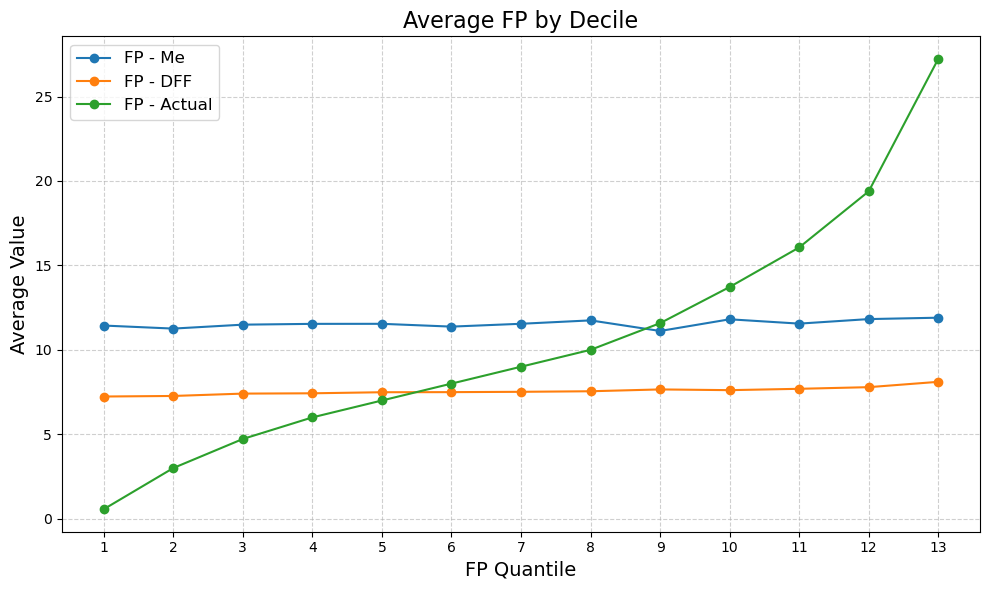

In [57]:
# Plot the averages
plt.figure(figsize=(10, 6))

# Plot FP averages
plt.plot(batters_quantile_averages['FP_quantile'], batters_quantile_averages['Avg_FP'], marker='o', label='FP - Me')

# Plot FP_DFF averages
plt.plot(batters_quantile_averages['FP_quantile'], batters_quantile_averages['Avg_FP_DFF'], marker='o', label='FP - DFF')

# Plot fp averages
plt.plot(batters_quantile_averages['FP_quantile'], batters_quantile_averages['Avg_fp'], marker='o', label='FP - Actual')

# Add titles and labels
plt.title('Average FP by Decile', fontsize=16)
plt.xlabel('FP Quantile', fontsize=14)
plt.ylabel('Average Value', fontsize=14)
plt.xticks(batters_quantile_averages['FP_quantile'])
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


##### Pitchers

Merge DFF projections onto my projections

In [58]:
pitchers_with_dff = pitchers_merged_df.drop_duplicates(['fullName', 'date']).merge(dff_df, on=['fullName', 'date'], how='inner')

Create error and success measures

In [59]:
pitchers_with_dff['error_me'] = (pitchers_with_dff['fp'] - pitchers_with_dff['FP'])
pitchers_with_dff['error_dff'] = (pitchers_with_dff['fp'] - pitchers_with_dff['FP_DFF'])

pitchers_with_dff['error_me2'] = pitchers_with_dff['error_me'] ** 2
pitchers_with_dff['error_dff2'] = pitchers_with_dff['error_dff'] ** 2

pitchers_with_dff['beat_dff'] = (pitchers_with_dff['error_me2'] < pitchers_with_dff['error_dff2']).astype('int')

##### Summary Statistics

In [60]:
pitcher_summary_stats = pd.DataFrame(pitchers_with_dff.dropna().query('starter == 1')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].mean())
pitcher_summary_stats.columns = ['Pitchers']
pitcher_summary_stats

,Pitchers
FP,14.235420
FP_DFF,13.842236
fp,13.877384
error_me,-0.358036
error_dff,0.035148
error_me2,207.275550
error_dff2,105.343683
beat_dff,0.350858


##### Quantiled

In [61]:
# Set number of quantiles
quantiles = 20

# Filter the dataframe
pitchers_filtered_df = pitchers_with_dff.query('FP > 4 and FP_DFF > 4')

# Create deciles based on FP
pitchers_filtered_df['FP_quantile'] = pd.qcut(pitchers_filtered_df['fp'], quantiles, labels=False) + 1

# Group by deciles and calculate averages for FP and FP_DFF
pitchers_quantile_averages = (pitchers_filtered_df.groupby('FP_quantile').agg(Avg_FP=('FP', 'mean'), Avg_FP_DFF=('FP_DFF', 'mean'), Avg_fp=('fp', 'mean')).reset_index())

pitchers_quantile_averages

,FP_quantile,Avg_FP,Avg_FP_DFF,Avg_fp
0,1,15.507539,12.907753,-7.928947
1,2,15.625996,12.172201,-1.572938
2,3,16.144860,12.792122,1.486702
3,4,17.622751,13.465206,3.848942
4,5,16.530410,13.148505,5.752105
5,6,17.209045,13.214489,7.567632
6,7,17.006495,13.451989,9.154737
7,8,17.901680,13.500426,10.530000
8,9,17.126274,13.636180,12.074603
9,10,17.600258,13.601619,13.692526


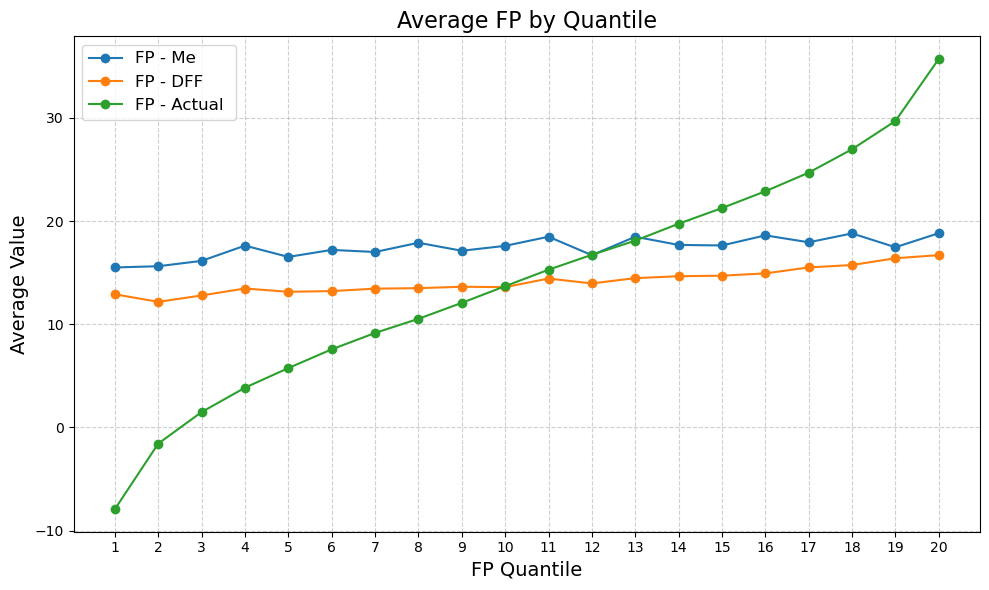

In [62]:
# Plot the averages
plt.figure(figsize=(10, 6))

# Plot FP averages
plt.plot(pitchers_quantile_averages['FP_quantile'], pitchers_quantile_averages['Avg_FP'], marker='o', label='FP - Me')

# Plot FP_DFF averages
plt.plot(pitchers_quantile_averages['FP_quantile'], pitchers_quantile_averages['Avg_FP_DFF'], marker='o', label='FP - DFF')

# Plot fp averages
plt.plot(pitchers_quantile_averages['FP_quantile'], pitchers_quantile_averages['Avg_fp'], marker='o', label='FP - Actual ')

# Add titles and labels
plt.title('Average FP by Quantile', fontsize=16)
plt.xlabel('FP Quantile', fontsize=14)
plt.ylabel('Average Value', fontsize=14)
plt.xticks(pitchers_quantile_averages['FP_quantile'])
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

Write to Excel

In [63]:
projection_evaluation_path = os.path.join(baseball_path, "C02. Players", "2. Competitor Projection Evaluations", f"Competitor Projection Evaluation {todaysdate}.xlsx")

Summary Statistics

In [64]:
summary_stats = pd.concat([batter_summary_stats, pitcher_summary_stats], axis=1)
summary_stats.to_excel(projection_evaluation_path, sheet_name='Summary Stats')

Quantiles

In [65]:
# Append the new DataFrame
with pd.ExcelWriter(projection_evaluation_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    batters_quantile_averages.to_excel(writer, sheet_name='BatterQuantiles', index=False)

In [66]:
# Append the new DataFrame
with pd.ExcelWriter(projection_evaluation_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pitchers_quantile_averages.to_excel(writer, sheet_name='PitcherQuantiles', index=False)

In [69]:
batters_with_dff[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,41525.000000,41525.000000,41525.000000,41525.000000,41525.000000,41525.000000,41525.000000,41525.000000
mean,7.130269,7.244426,6.893438,-0.236832,-0.350988,97.870787,49.603655,0.404551
std,7.038346,1.493633,7.114636,9.890250,7.034320,176.070340,102.529846,0.490811
min,0.000000,0.390000,0.000000,-52.000000,-16.800000,0.000000,0.000000,0.000000
25%,2.000000,6.386000,2.000000,-6.000000,-5.520000,4.000000,5.861241,0.000000
50%,5.000000,7.208000,5.000000,0.000000,-2.208000,25.000000,23.980609,0.000000
75%,10.000000,8.100000,10.000000,5.000000,2.896000,121.000000,51.984100,1.000000
max,55.000000,19.228000,81.000000,61.000000,69.030000,3721.000000,4765.140900,1.000000
